In [1]:
import math
from io import BytesIO

import psycopg2
import postgis
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from solml import download
from solml.compute import compute_angle

%matplotlib inline

In [2]:
nb_worker = 100
id_worker = 19
compute_angle.process_building(nb_worker, id_worker)

251428219

In [3]:
id_osm = 251428219

In [4]:
import configparser
import os

# Read config

config = configparser.ConfigParser()
config.read('../config.ini')
database_host = config['main']['database_host']
database_port = config['main']['database_port']
database_name = config['main']['database_name']
database_username = config['main']['database_username']
database_password = config['main']['database_password']
assert database_host == 'localhost'
assert database_port == '1234'


In [5]:
connection = psycopg2.connect(dbname=database_name, user=database_username, password=database_password)
cursor = connection.cursor()
postgis.register(cursor)

cursor.execute("""
    select original_image, angle_rad, size_WM_X, size_WM_Y
    from buildings
    where id_osm=%s
    ;
    """, [id_osm])
data = cursor.fetchall()[0]
original_bytes, angle_rad, size_WM_X, size_WM_Y = data


cursor.close()
connection.close()


In [6]:

buffer = BytesIO(original_bytes)
original_image = Image.open(buffer)

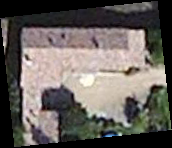

In [7]:
angle_degree = angle_rad * 180. / math.pi
straight_image = original_image.rotate(-angle_degree, resample=Image.BICUBIC, expand=True)
straight_array = np.asarray(straight_image)
straight_size_X, straight_size_Y, _ = straight_array.shape
straight_image

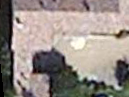

In [8]:
size_X = size_WM_X / download.pixelSizeX
size_Y = - size_WM_Y / download.pixelSizeY
size_X_with_border = int(math.ceil(size_X + 10))
size_Y_with_border = int(math.ceil(size_Y + 10))
offset_X = int((straight_size_X / 2.) - (size_X_with_border / 2.))
offset_Y = int((straight_size_Y / 2.) - (size_Y_with_border / 2.))
cropped_array = straight_array[offset_Y:offset_Y+size_Y_with_border, offset_X:offset_X+size_X_with_border]
cropped_image = Image.fromarray(cropped_array)
cropped_image